In [1]:
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model

In [2]:
image_directory = r'D:\Projects\ODIR\ODIRCODE\PreprocessingCodes\Input_224/'


#Now let us read metadata to get our Y values (multiple lables)
df = pd.read_csv(r'D:\Projects\ODIR\ODIRCODE\Prepro\ground_truth\all\odirALL.csv')    
print(df.head())     # printing first five rows of the file
print(df.columns)

df = df.iloc[:23000]  #Loading only first 1000 datapoints for memory reasons 
#Need to read images using the tag from metadata.
#Otherwise, if read directly from the folder then images may not correspond to 
#the metadata from the csv file. 

            ID  Normal  Diabetes  Glaucoma  Cataract  AMD  Hypertension  \
0   0_left.jpg       0         0         0         1    0             0   
1  0_right.jpg       1         0         0         0    0             0   
2   1_left.jpg       1         0         0         0    0             0   
3  1_right.jpg       1         0         0         0    0             0   
4   2_left.jpg       0         1         0         0    0             0   

   Myopia  Others  Total  
0       0       0      1  
1       0       0      1  
2       0       0      1  
3       0       0      1  
4       0       1      2  
Index(['ID', 'Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD',
       'Hypertension', 'Myopia', 'Others', 'Total'],
      dtype='object')


In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
SIZE = 224
X_dataset = []  
for i in tqdm(range(df.shape[0])):
    img = load_img(image_directory +df['ID'][i], target_size=(SIZE,SIZE,3))   
    img = img_to_array(img)
    img = img/255.
    X_dataset.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 22032/22032 [01:29<00:00, 246.93it/s]


In [4]:
X = np.array(X_dataset)

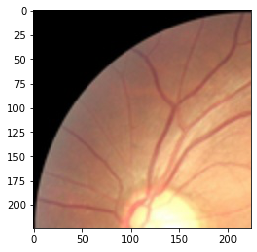

In [5]:
from matplotlib import pyplot as plt
plt.imshow(X[21000], interpolation='nearest')
plt.show()

In [6]:
#
print(df['ID'][500])  #King Kong

print(df['Total'][500])  #Tagged as multiple Genres.

#Id and Genre are not labels to be trained. So drop them from the dataframe.

268_left.jpg
2


In [7]:
y = np.array(df.drop(['ID', 'Total'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint1 = ModelCheckpoint(filepath=r'D:\Projects\ODIR\ODIRCODE\bestres\InceptionV3\my_best_model.epoch{epoch:03d}-loss{val_loss:.2f}.hdf5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
checkpoint2 = ModelCheckpoint(filepath=r'D:\Projects\ODIR\ODIRCODE\bestres\InceptionV3\my_best_model.epoch{epoch:03d}-acc{val_accuracy:.2f}.hdf5', 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint1,checkpoint2]
inc=InceptionV3(input_shape=(224,224,3),weights='imagenet', include_top=False)
for i in inc.layers:
    i.trainable=True
x=Flatten()(inc.output)
pred=Dense(8,activation='sigmoid')(x)
model=Model(inputs=inc.input,outputs=pred)

In [10]:
model.summary()

#Binary cross entropy of each label. So no really a binary classification problem but
#Calculating binary cross entropy for each label. 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=150,callbacks=callbacks, validation_data=(X_test, y_test), batch_size=10)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

15420/15422 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8470
Epoch 00001: val_loss improved from inf to 5.98752, saving model to D:\Projects\ODIR\ODIRCODE\bestres\InceptionV3\my_best_model.epoch001-loss5.99.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.82161, saving model to D:\Projects\ODIR\ODIRCODE\bestres\InceptionV3\my_best_model.epoch001-acc0.82.hdf5
15422/15422 [==============================] - 101s 7ms/sample - loss: 0.4042 - accuracy: 0.8470 - val_loss: 5.9875 - val_accuracy: 0.8216
Epoch 2/150
15410/15422 [============================>.] - ETA: 0s - loss: 0.3814 - accuracy: 0.8500
Epoch 00002: val_loss improved from 5.98752 to 0.37574, saving model to D:\Projects\ODIR\ODIRCODE\bestres\InceptionV3\my_best_model.epoch002-loss0.38.hdf5

Epoch 00002: val_accuracy improved from 0.82161 to 0.85202, saving model to D:\Projects\ODIR\ODIRCODE\bestres\InceptionV3\my_best_model.epoch002-acc0.85.hdf5
15422/15422 [==============================] - 86s

15410/15422 [============================>.] - ETA: 0s - loss: 0.2381 - accuracy: 0.8968
Epoch 00018: val_loss did not improve from 0.24507

Epoch 00018: val_accuracy did not improve from 0.89399
15422/15422 [==============================] - 86s 6ms/sample - loss: 0.2382 - accuracy: 0.8967 - val_loss: 0.2548 - val_accuracy: 0.8924
Epoch 19/150
15410/15422 [============================>.] - ETA: 0s - loss: 0.2430 - accuracy: 0.8946
Epoch 00019: val_loss did not improve from 0.24507

Epoch 00019: val_accuracy did not improve from 0.89399
15422/15422 [==============================] - 85s 6ms/sample - loss: 0.2432 - accuracy: 0.8946 - val_loss: 0.2545 - val_accuracy: 0.8894
Epoch 20/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.2405 - accuracy: 0.8958
Epoch 00020: val_loss did not improve from 0.24507

Epoch 00020: val_accuracy improved from 0.89399 to 0.89427, saving model to D:\Projects\ODIR\ODIRCODE\bestres\InceptionV3\my_best_model.epoch020-acc0.89.hdf5
15422/1

Epoch 39/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9642
Epoch 00039: val_loss did not improve from 0.22979

Epoch 00039: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0901 - accuracy: 0.9642 - val_loss: 0.2959 - val_accuracy: 0.9017
Epoch 40/150
15410/15422 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9662
Epoch 00040: val_loss did not improve from 0.22979

Epoch 00040: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0858 - accuracy: 0.9662 - val_loss: 0.3328 - val_accuracy: 0.8975
Epoch 41/150
15410/15422 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9692
Epoch 00041: val_loss did not improve from 0.22979

Epoch 00041: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0785 - accuracy: 0.9692 -

Epoch 63/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0193 - accuracy: 0.9934
Epoch 00063: val_loss did not improve from 0.22979

Epoch 00063: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0193 - accuracy: 0.9934 - val_loss: 0.5016 - val_accuracy: 0.9029
Epoch 64/150
15410/15422 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9940
Epoch 00064: val_loss did not improve from 0.22979

Epoch 00064: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0172 - accuracy: 0.9940 - val_loss: 0.5137 - val_accuracy: 0.8998
Epoch 65/150
15410/15422 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9904
Epoch 00065: val_loss did not improve from 0.22979

Epoch 00065: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0285 - accuracy: 0.9904 -

Epoch 87/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9962
Epoch 00087: val_loss did not improve from 0.22979

Epoch 00087: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.5922 - val_accuracy: 0.9007
Epoch 88/150
15410/15422 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9958
Epoch 00088: val_loss did not improve from 0.22979

Epoch 00088: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0117 - accuracy: 0.9958 - val_loss: 0.6733 - val_accuracy: 0.9031
Epoch 89/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980
Epoch 00089: val_loss did not improve from 0.22979

Epoch 00089: val_accuracy did not improve from 0.90418
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0059 - accuracy: 0.9980 -

15410/15422 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9979
Epoch 00110: val_loss did not improve from 0.22979

Epoch 00110: val_accuracy did not improve from 0.90507
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.6674 - val_accuracy: 0.8998
Epoch 111/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9975
Epoch 00111: val_loss did not improve from 0.22979

Epoch 00111: val_accuracy did not improve from 0.90507
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.7055 - val_accuracy: 0.9048
Epoch 112/150
15410/15422 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9970 ETA: 1s
Epoch 00112: val_loss did not improve from 0.22979

Epoch 00112: val_accuracy did not improve from 0.90507
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0086 - accuracy: 0.9970 - va

15420/15422 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9975
Epoch 00133: val_loss did not improve from 0.22979

Epoch 00133: val_accuracy did not improve from 0.90562
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.6604 - val_accuracy: 0.9042
Epoch 134/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9981
Epoch 00134: val_loss did not improve from 0.22979

Epoch 00134: val_accuracy did not improve from 0.90562
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.7271 - val_accuracy: 0.9024
Epoch 135/150
15420/15422 [============================>.] - ETA: 0s - loss: 0.0056 - accuracy: 0.9981
Epoch 00135: val_loss did not improve from 0.22979

Epoch 00135: val_accuracy did not improve from 0.90562
15422/15422 [==============================] - 84s 5ms/sample - loss: 0.0056 - accuracy: 0.9981 - val_loss: 

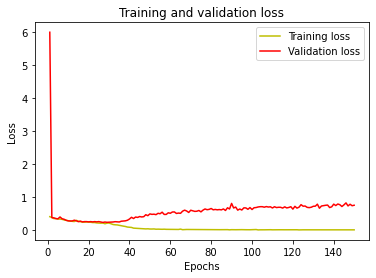

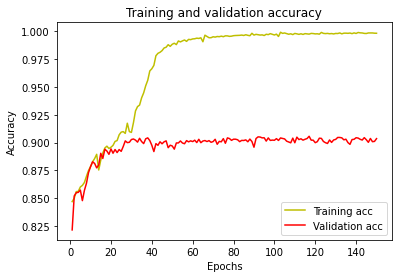

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
# MLP for Pima Indians Dataset saved to single file
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model.save(r"D:\Projects\ODIR\ODIRCODE\inceptionV3Secondtime\final\modelke.h5")
print("Saved model to disk")
# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
# save model and architecture to single file
model.save(r"D:\Projects\ODIR\ODIRCODE\inceptionV3Secondtime\final\ke2model.h5")
print("Saved model to disk")

Saved model to disk
accuracy: 99.92%
Saved model to disk


In [13]:
...
# equivalent to: model.save("model.h5")
from tensorflow.keras.models import save_model
save_model(model, r"D:\Projects\ODIR\ODIRCODE\inceptionV3Secondtime\final\model2.h5")

In [14]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense
import numpy
import os

# evaluate the model
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 
# serialize model to JSON
model_json = model.to_json()
with open(r"D:\Projects\ODIR\ODIRCODE\inceptionV3Secondtime\final\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(r"D:\Projects\ODIR\ODIRCODE\inceptionV3Secondtime\final\modeljs.h5")
print("Saved model to disk")


accuracy: 99.92%
Saved model to disk


In [15]:
from tensorflow.keras.models import Sequential, model_from_yaml
from tensorflow.keras.layers import Dense
import numpy
import os

# serialize model to YAML
model_yaml = model.to_yaml()
with open(r"D:\Projects\ODIR\ODIRCODE\inceptionV3Secondtime\final\model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(r"D:\Projects\ODIR\ODIRCODE\inceptionV3Secondtime\final\modelya.h5")
print("Saved model to disk")
 


Saved model to disk
